# A/B Testing Online Shop

Daftar Isi :
- Pendahuluan
- Pra-pemrosesan Data
    - Mengimpor Library
    - Memuat Data
- Memprioritaskan Hipotesis
    - Framework ICE
    - Framework RICE
- Menganalisa A/B Testing
- Kesimpulan

# Pendahuluan
Sebagai data analis di sebuah online shop berskala besar, saya bersama tim pemasaran telah menyusun daftar hipotesis untuk membantu meningkatkan pendapatan. Hal ini tentunya penting untuk menghemat biaya lain yang sebenarnya tidak perlu dan ini tentunya dapat menghindarkan kita dari membuang waktu dan menjalankan rencana yang tidak dapat memberikan hasil maksimal terhadap pendapatan online shop.

Saya akan melakukan pemrosesan data,memprioritaskan hipotesis tersebut, menjalankan A/B testing, dan menganalisis hasilnya.
Dan juga memberikan kesimpulan terhadap hasil testing tersebut.

## Pra-pemrosesan Data
### Mengimpor Library

In [1]:
import pandas as pd
import datetime as dt
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.dates as mdates

### Memuat Data
#### Dataset Hypothesis
Dataset pertama yang akan kita muat adalah dataset hypothesis yang berisi kolom berikut:
- Hypotheses — deskripsi singkat tentang hipotesis
- Reach — jangkauan pengguna, dalam skala satu hingga sepuluh
- Impact — dampak terhadap pengguna, dalam skala satu hingga sepuluh
- Confidence — keyakinan pada hipotesis, dalam skala satu sampai sepuluh
- Effort — sumber daya yang diperlukan untuk menguji hipotesis, dalam skala satu sampai sepuluh. Semakin tinggi nilai Effort, semakin intensif sumber daya pengujiannya.

In [2]:
# memuat data
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [3]:
# memuat informasi umum
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
# mengecek nilai duplikat
hypotheses.duplicated().sum()

0

Tidak ada missing values serta nilai duplikat pada dataset ini. Mari kita lihat dataset berikutnya.

#### Dataset Orders
Berikutnya kita akan memuat dataset orders yang berisi kolom berikut:
- transactionId — ID pesanan
- visitorId — ID pengguna yang membuat pesanan
- date — tanggal dibuatnya pesanan
- revenue — pendapatan dari pesanan
- group — kelompok uji (test group) A/B tempat pengguna berada

In [5]:
# memuat data
orders = pd.read_csv('/datasets/orders_us.csv')
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [6]:
# memuat informasi umum
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [7]:
# mengecek missing value
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [8]:
# mengecek nilai duplikat
orders.duplicated().sum()

0

Tidak ada missing values dan nilai duplikat juga dalam dataset orders. Namun kita perlu mengubah tipe data object pada kolom date menjadi datetime. Kemudian kita perlu memastikan bahwa tidak ada pengunjung yang berada pada kedua grup A dan B. Hal ini untuk menghindari kesalahan pada saat melakukan testing nanti.

In [9]:
# mengubah tipe data kolom date
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [10]:
# memastikan tidak ada visitor yang berada di kedua grup
group_counts = orders.groupby('visitorId').agg({'group': 'nunique'}) ##list of users with number of groups
to_include = group_counts[group_counts['group'] == 1] ##filter for just users in 1 group
orders = orders[orders['visitorId'].isin(to_include.index)]

In [11]:
# menemapilkan informasi umum terbaru
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   float64       
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 47.6+ KB


Setelah difilter, ada 181 pengunjung yang ternyata berada di kedua grup. Hasil ini tentunya harus dihapus karena dapat menimbulkan masalah saat pengujian yang akan dilakukan nanti. Dengan ini maka kita sudah memiliki data yang bersih.

#### Dataset Visitors
Dataset ini merupakan dataset terakhir yang kita muat, dataset ini berisi kolom:
- date — tanggal
- group — kelompok uji (test group) A/B
- visits — jumlah kunjungan pada tanggal yang ditentukan untuk kelompok uji A/B yang ditentukan

In [12]:
# memuat data
visitors = pd.read_csv('/datasets/visitors_us.csv')
visitors.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [13]:
# menampilkan informasi umum
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [14]:
# mengecek missing value
visitors.isna().sum()

date      0
group     0
visits    0
dtype: int64

In [15]:
# mengecek nilai duplikat
visitors.duplicated().sum()

0

Dataset ini juga tidak memiliki missing values dan nilai yang hilang, namun kita perlu mengubah tipe data object pada kolom date menjadi datetime.

In [16]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [17]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Kita telah selesai melakukan pra-pemrosesan data pada ketiga dataset ini. Tidak ditemukan nilai duplikat maupun missing values. Adapun kita melakukan pengecekan terhadap kemungkinan pengunjung berada dalam kedua grup testing, jumlah pengunjung ini telah kita filter sehingga kita akan melakukan pengujian menggunakan data yang sudah bersih.

## Memprioritaskan Hipotesis

Setelah kita selesai melakukan pra-pemrosesan data, kita akan melakukan tahap berikutnya yaitu memprioritaskan hipotesis. Kita telah memiliki beberapa hipotesis dalam dataset hypotheses dan kita akan menerapkan framework ICE dan RICE pada hipotesis ini.

### Framework ICE

In [18]:
# menampilkan hipotesis
hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [19]:
# menghitung score ICE
hypotheses['ICE'] = (hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Effort']

# menampilkan score ICE dalam urutan prioritas menurun
hypotheses[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,Launch a promotion that gives users discounts ...,16.200000
0,Add two new channels for attracting traffic. T...,13.333333
7,Add a subscription form to all the main pages....,11.200000
6,Show banners with current offers and sales on ...,8.000000
2,Add product recommendation blocks to the store...,7.000000
1,Launch your own delivery service. This will sh...,2.000000
5,Add a customer review page. This will increase...,1.333333
3,Change the category structure. This will incre...,1.125000
4,Change the background color on the main page. ...,1.000000


Dengan framework ICE, hipotesis nomor 8 memiliki skor tertinggi disusul dengan hipotesis nomor 0 dan 7. Membuat promosi yang memberikan diskon untuk pengguna nampaknya menjanjikan. Disusul dengan menambahkan 2 channel untuk menarik traffic sepertinya adalah kombinasi yang bagus. 

### Framework RICE

In [20]:
# menghitung score RICE
hypotheses['RICE'] = (hypotheses['Reach'] * hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Effort']

# menampilkan score ICE dalam urutan prioritas menurun
hypotheses[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,Add a subscription form to all the main pages....,112.0
2,Add product recommendation blocks to the store...,56.0
0,Add two new channels for attracting traffic. T...,40.0
6,Show banners with current offers and sales on ...,40.0
8,Launch a promotion that gives users discounts ...,16.2
3,Change the category structure. This will incre...,9.0
1,Launch your own delivery service. This will sh...,4.0
5,Add a customer review page. This will increase...,4.0
4,Change the background color on the main page. ...,3.0


Dari skor RICE diatas, hasil hipotesis yang unggul adalah nomor 7 dan nomor 2 dengan skor setengah dari nomor 7. Ternyata menambahkan form pendaftaran pada semua halaman utama mungkin dapat membuat pengunjung mendaftar dan membeli produk. Menambahkan rekomendasi produk juga memiliki peluang untuk membuat pengunjung ingin membeli produk tersebut saat melihat-lihat halaman atau mencari produk serupa.

Dengan memberlakukan pendaftaran untuk pengunjung baru yang belum memiliki akun, dapat menambah potensi pengunjung untuk melakukan pembelian. Dan promosi untuk memberikan diskon juga dapat membuat pengunjung berpeluang untuk melakukan transaksi walau bisa jadi produk tersebut sebenarnya belum dibutuhkan oleh pengguna.

## Menganalisa A/B Testing
Setelah mengaplikasikan framework ICE dan RICE pada hipotesis, kita akan melanjutkan ke tahap berikut yaitu menganalisa A/B testing untuk melihat hipotesis mana yang lebih baik untuk meningkatkan pendapatan.
Pertama kita akan menggambarkan pendapatan kumulatif berdasarkan kelompok.

### Grafik Pendapatan Kumulatif
Untuk dapat membuat grafik ini, kita perlu membuat dataframa yang memuat data kumulatif terlebih dulu.

In [21]:
# building an array with unique paired date-group values 
datesGroups = orders[['date','group']].drop_duplicates()

# membuat dataframe baru yang memuat jumlah order berdasarkan grup dan id unik pengguna
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg
    ({'date' : 'max', 
      'group' : 'max', 
      'transactionId' : pd.Series.nunique, 
      'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}),axis=1).sort_values(by=['date','group'])

In [22]:
# membuat dataframe baru yang memuat jumlah kunjungan berdasarkan grup
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg
    ({'date' : 'max',
      'group' : 'max',
      'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [23]:
# merging the two tables into one and giving its columns descriptive names
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visits']

# menampilkan dataframe
cumulativeData.head()

,date,group,orders,buyers,revenue,visits
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845


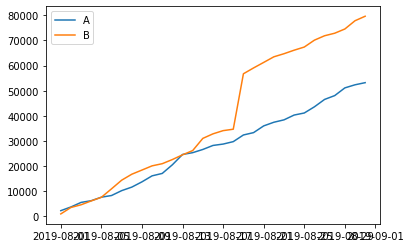

In [24]:
# DataFrame with cumulative orders and cumulative revenue by day, group A
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# DataFrame with cumulative orders and cumulative revenue by day, group B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Plotting the group A revenue graph 
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Plotting the group B revenue graph 
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
# mengatur size grafik
rcParams['figure.figsize'] = 20,10

Revenue untuk kedua grup semakin naik, meskipun revenue untuk grup A masih berada cukup jauh dibawah revenue grup B. Setidaknya revenue kita tidak mengalami penurunan signifikan. Namun jika diperhatikan, untuk revenue grup B mengalami kenaikan drastis, ini mungkin disebabkan oleh pembelian dengan nominal besar. Ini bisa jadi merupakan anomali.

### Grafik Pesanan Rata-rata
Selanjutnya kita membuat grafik untuk pesanan rata-rata berdasarkan kelopok. Kita akan membagi pendapatan kumulatif masing-masing grup dan membaginya dengan masing-masing jumlah order.

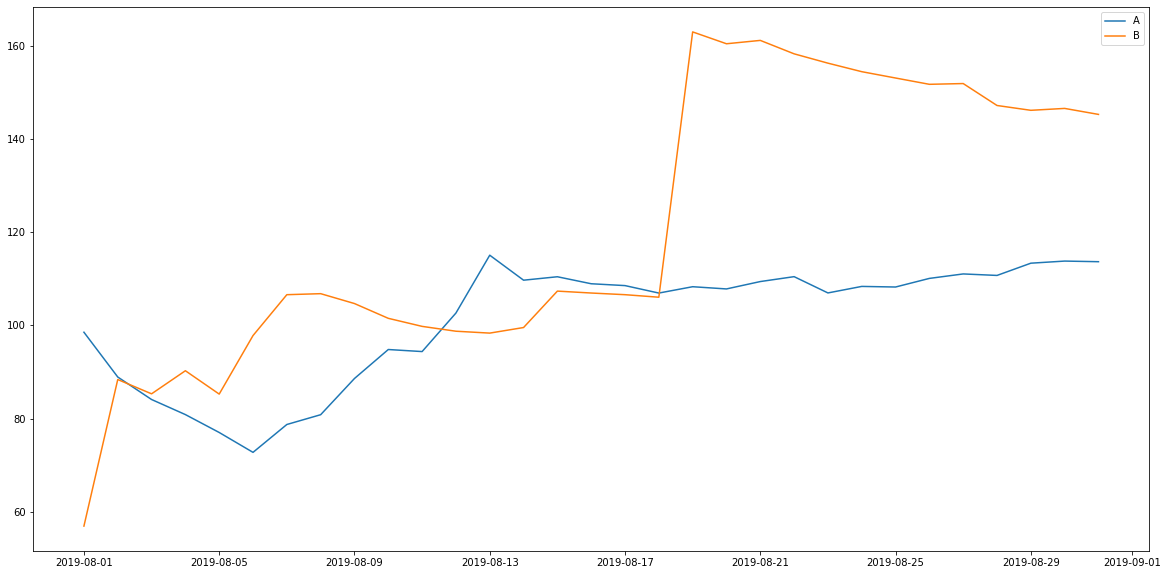

In [25]:
# membuat grafik
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()

# mengatur size grafik
rcParams['figure.figsize'] = 20,10

Dapat dilihat jika rata-rata pesanan mengalami penurunan dan kenaikan yang tidak stabil. Seperti pada grafik sebelumnya, grup B mengalami lonjakan kenaikan drastis yang sepertinya dikarenakan nominal order yang tinggi.

### Grafik Perbedaan Relatif Pesanan Rata-rata Kumulatif
Selanjutnya kita akan membuat grafik untuk perbedaan relatif untuk ukuran pesanan rata-rata kumulatif kelompok B yang dibandingkan dengan kelompok A. Kita perlu menggabungkan dataframe yang memuat data kumulatif terlebih dulu.

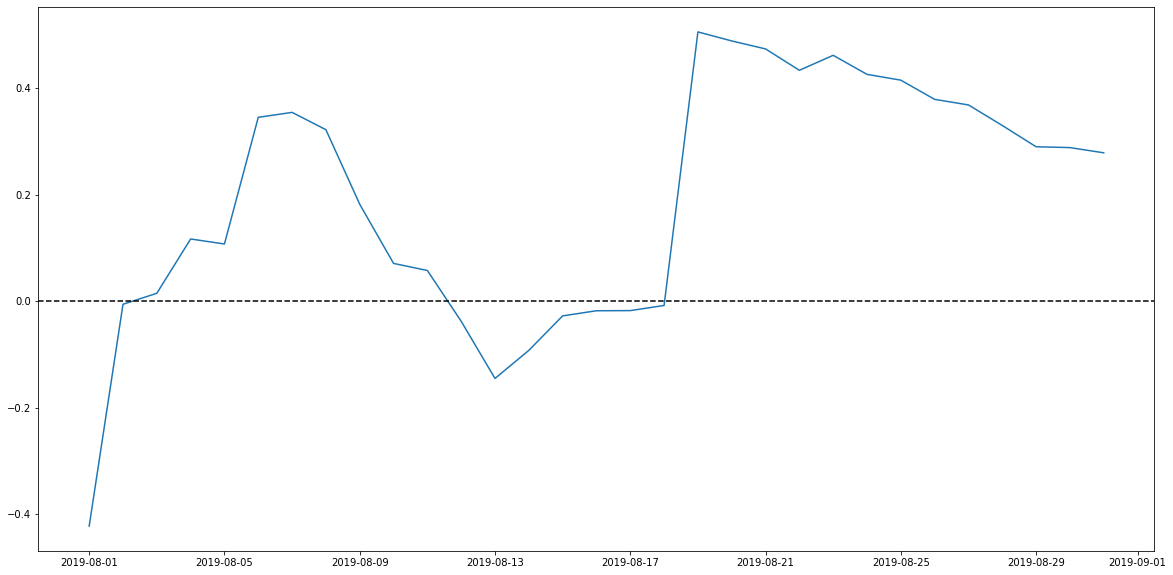

In [26]:
# gathering the data into one DataFrame
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', 
                                                   how='left', suffixes=['A', 'B'])

# plotting a relative difference graph for the average purchase sizes
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# adding the X axis
plt.axhline(y=0, color='black', linestyle='--')
rcParams['figure.figsize'] = 20,10

Ada beberapa bagian pada grafik yang menunjukkan adanya pesanan dengan nominal banyak, maka dari itu garisnya menukik tinggi lalu turun lagi cukup banyak. Kita akan menganalisa lebih lanjut mengenai hal ini nanti.

### Tingkat Konversi Harian
Lalu kita akan menghitung tingkat konversi setiap kelompok sebagai rasio pesanan terhadap jumlah kunjungan setiap hari. Kemudian membuat grafik tingkat konversi harian dari kedua kelompok dan menjelaskan perbedaannya.

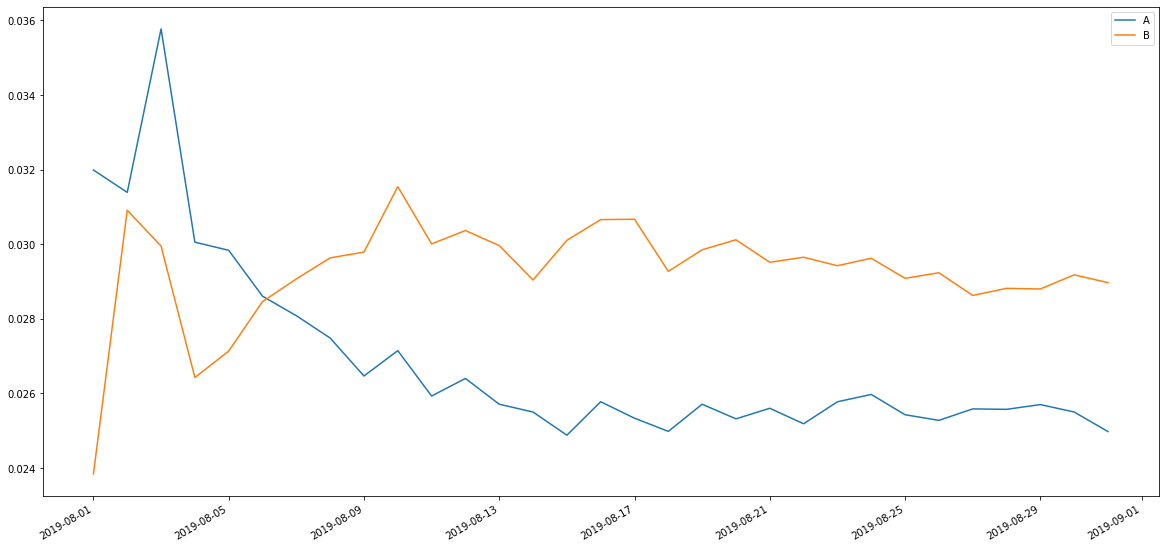

In [27]:
# calculating cumulative conversion
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visits']

# selecting data on group A 
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# selecting data on group B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# plotting the graphs
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# menentukan skala
dates = ['2019-08-01','2019-08-31']
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]

# membuat plot
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

Tingkat konversi harian terlihat lumayan simetris pada grafik diatas. Konversinya fluktuatif di sekitar value dan tanggal yang sama. Pada awalnya, konversi grup A dan B sama-sama naik tajam dan turun hampir bersamaan lalu perlahan mulai simetris dari tanggal 09-08-2019.

### Scatterplot Pesanan Per Pengguna
Berikutnya kita membuat scatterplot untuk jumlah pesanan per pengguna. Kita perlu menghitung k=jumlah pesanan per pengguna terlebih dulu.

In [28]:
# menghitung jumlah pesanan per pengguna
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['visitorId', 'orders']

# menampilkan hasilnya dalam urutan menurun
ordersByUsers.sort_values(by='orders', ascending=False)

,visitorId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
...,...,...
331,1438226485,1
332,1452540367,1
333,1455323168,1
334,1455861274,1


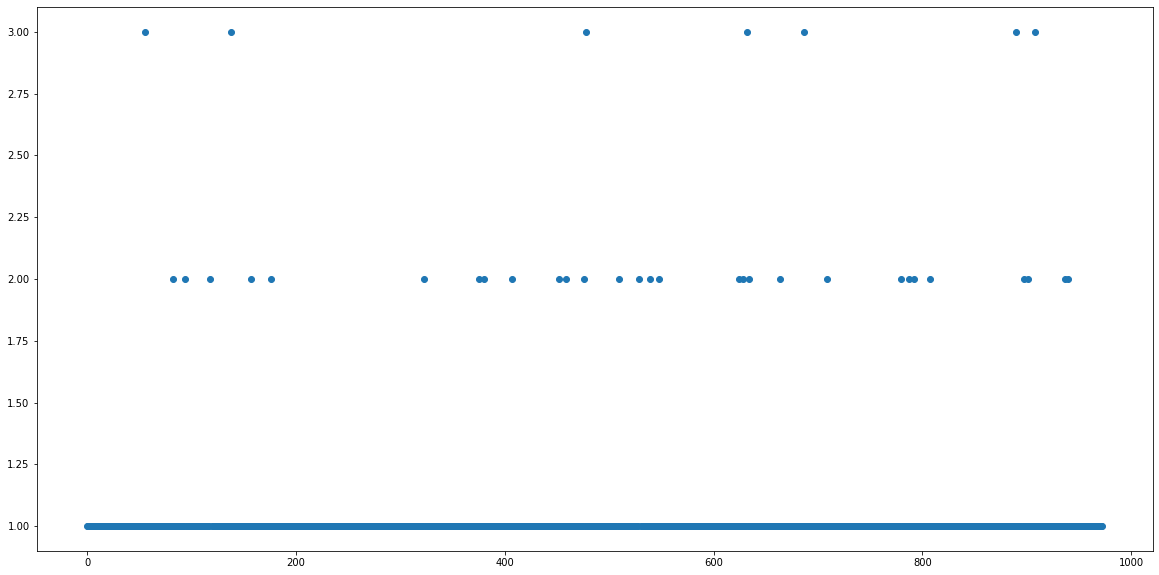

In [29]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])

Jumlah order yang dilakukan per pengunjung maksimal hanya 3 order saja, jumlah inipun termasuk sedikit sekali jika dilihat dari scatterplot diatas. Lalu 2 order per pengguna menyusul dibawahnya namun dengan jumlah yang lebih banyak dibandingkan 3 order. Dan jumlah order sebanyak 1 saja adalah yang paling banyak.

In [30]:
# menghitung persentil ke-95 dan ke-99 untuk jumlah pesanan per pengguna
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


Jumlah dari 1 order tidak lebih dari 5%, dan jumlah dari 2 order tidak lebih dari 1%

### Scatterplot Harga Pesanan

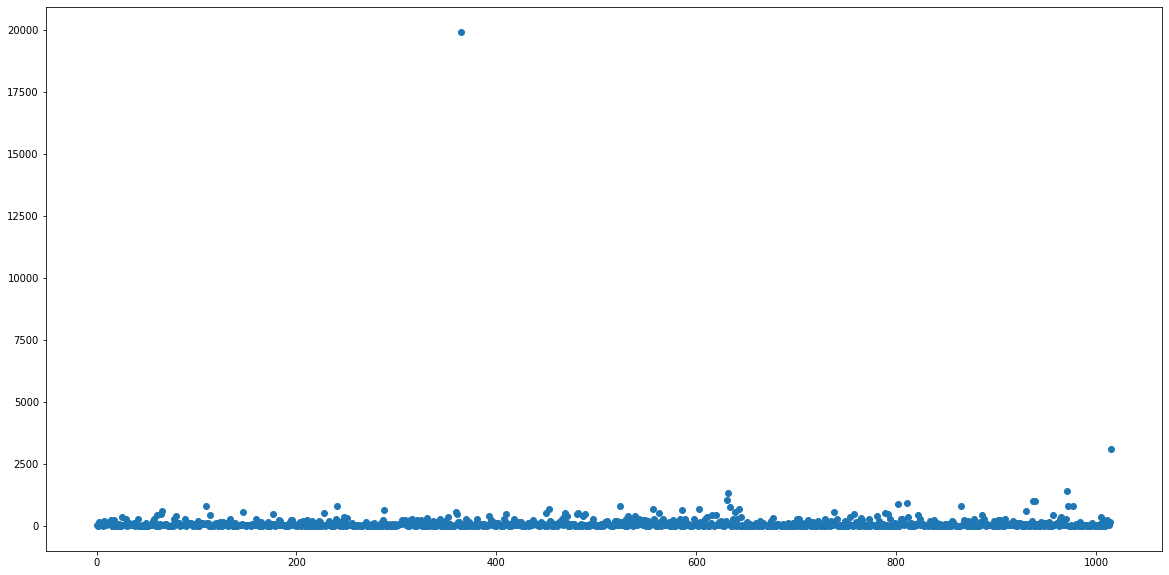

In [31]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

In [32]:
# menghitung persentil ke-95 dan ke-99 untuk jumlah pesanan per pengguna
print(np.percentile(orders['revenue'], [95, 99]))

[414.275 830.3  ]


Persentase biaya order diatas 414.275 tidak lebih dari 5%, dan persentase order diatas 830.3 tidak lebih dari 1%. Dapat dilihat bahwa titik biaya pesanan 20.000 sepertinya adalah anomali. Pesanan ini bisa jadi penyebab grafik sebelumnya yang kita buat mengalami lonjakan naik dengan drastis.

### Signifikansi Statistik Konversi Antar Kelompok Dengan Data Mentah

Mari kita temukan signifikansi statistik dari perbedaan tingkat konversi dan ukuran pesanan antar kelompok menggunakan data "mentah" (yaitu data sebelum penghapusan anomali).
Kita akan mulai dengan mempersiapkan datanya.

Kita akan membuat variabel ordersByUsersA dan ordersByUsersB untuk menyimpan kolom 'userId' dan 'orders'. Untuk pengguna yang membuat setidaknya satu pesanan, kita akan menunjukkan jumlah pesanan yang dibuat.

In [33]:
# membuat variabel baru untuk jumlah pesanan berdasarkan grup
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

Selanjutnya, kita perlu membuat variabel sampleA dan sampleB, yang akan memuat pengguna dari kelompok yang berbeda dan jumlah pesanan yang sesuai. Untuk pengunjung yang tidak membuat pesanan, nilainya adalah 0. Hal ini dibutuhkan untuk mempersiapkan sampel pengujian Mann-Whitney.

Variabel sample akan memiliki dua bagian, yaitu:
1. List jumlah pesanan untuk setiap pengguna: ordersByUsers['orders'] sesuai grup.
2. Nilai nol untuk para pengguna yang tidak membuat pesanan. Jumlah mereka adalah selisih antara jumlah total pengunjung dan jumlah catatan pada pesanan: visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])
Kita akan membuat objek pd.Series dengan panjang yang dibutuhkan.

In [34]:
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')]

[0      1
 1      1
 2      1
 3      1
 4      1
       ..
 440    1
 441    1
 442    1
 443    1
 444    1
 Name: orders, Length: 445, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 18286    0
 18287    0
 18288    0
 18289    0
 18290    0
 Name: orders, Length: 18291, dtype: int64]

Kemudian, kita akan meneruskan argumen yang menunjukkan bahwa objek Series akan digabungkan dengan baris (dengan kata lain, ditulis secara berurutan) dengan pd.concat. Berikut inilah yang kita dapatkan setelah melakukan hal yang sama dengan sampleB:

In [35]:
sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visits'].sum() - 
                                                  len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(visitors[visitors['group']=='B']['visits'].sum() - 
                                                  len(ordersByUsersB['orders'])), name='orders')],axis=0)

Jumlah elemen sampleA adalah jumlah pengguna, dan jumlah total semua elemen adalah jumlah pesanan. Untuk mengetahui tingkat konversi kelompok, kita harus membagi jumlah total pesanan dengan jumlah pengguna. Dengan menggunakan metode mean(), kita akan menemukan nilai rata-rata untuk sampleA. Cara yang sama juga akan kita terapkan untuk menemukan tingkat konversi pada kelompok B: sampleB.mean(). Berikut hasil yang kita dapatkan.

In [36]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

0.011
0.160


Kesimpulan: berdasarkan data mentah yang kita gunakan, ternyata ada perbedaan antara kelompok A dan B.
Baris pertama dari output yang dihasilkan memberi kita nilai p sebesar 0,011, yang berarti lebih kecil dari 0,05. Oleh karena itu, kita menerima hipotesis nol karena ditemukan perbedaan yang signifikan secara statistik dalam konversi antar kelompok. Dan ada kenaikan relatif dari kelompok B adalah 16% (baris kedua dari output).

### Signifikansi Statistik Pesanan Rata-rata Dengan Data Mentah
Untuk menghitung signifikansi statistik dari perbedaan ukuran pesanan rata-rata segmen, kita akan meneruskan data pendapatan ke kriteria mannwhitneyu().
Kita juga akan menemukan perbedaan relatif pada ukuran pesanan rata-rata antar kelompok:

In [37]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.862
0.278


Nilai p jauh lebih tinggi daripada 0.05, sehingga kita tidak bisa menolak hipotesis nol dan menyimpulkan bahwa ukuran pesanan rata-rata antar kelompok adalah berbeda. Namun, ukuran pesanan rata-rata untuk kelompok B cukup jauh lebih kecil daripada kelompok A.

### Signifikansi Statistik Konversi Antar Kelompok Dengan Data Terfilter
Selanjutnya kita akan mencari tahu tentang signifikansi statistik perbedaan konversi antar kelompok menggunakan data yang telah difilter. Pada persentil ke-95 dan ke-99 untuk jumlah pesanan per pengguna adalah 1 dan 2 pesanan. 
Mari kita definisikan pengguna yang tidak wajar (anomali) sebagai pengguna yang membuat lebih dari satu pesanan dengan nilai di atas $20.000. 

Dengan demikian, kita akan menghapus 5% pengguna dengan jumlah pesanan paling banyak, dan 1--5% pengguna dengan nilai pesanan paling tinggi. Mari kita buat irisan data dengan pengguna yang membuat lebih dari empat pesanan (usersWithManyOrders) dan pengguna yang membuat pesanan di atas $20.000 (usersWithExpensiveOrders). Kita akan menggabungkan mereka ke dalam tabel abnormalUsers.

In [38]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 1]['visitorId'], 
                                 ordersByUsersB[ordersByUsersB['orders'] > 1]['visitorId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 20000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

33    249864742
36    366673373
51    406208401
67    522292794
58    611059232
Name: visitorId, dtype: int64
(36,)


Secara total, kita memiliki 36 pengguna yang tidak wajar atau anomali.
Mari kita cari tahu dampak tindakan mereka terhadap hasil pengujian.

### Signifikansi Statistik Perbedaan Pesanan Rata-rata Antar kelompok Dengan data Terfilter
Kita akan menghitung signifikansi statistik dari perbedaan konversi antar kelompok menggunakan data yang telah difilter. Pertama-tama, kita akan menyiapkan sampel jumlah pesanan per pengguna untuk setiap kelompok uji:

In [39]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visits'].sum() - 
                                                          len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(visitors[visitors['group']=='B']['visits'].sum() - 
                                                          len(ordersByUsersB['orders'])),name='orders')],axis=0)

Selanjutnya, kita akan menerapkan kriteria statistik Mann-Whitney pada sampel yang dihasilkan:

In [40]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.009
0.183


Hasilnya memiliki sedikit perbedaan. Sebagai pengingat, hasil sebelumnya adalah 0.011 dan 0.160

Mari kita lihat apa yang terjadi pada nilai ukuran pesanan rata-rata:

In [41]:
print('{0:.3f}'.format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print('{0:.3f}'.format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

0.932
0.332


Hasilnya pun memiliki perbedaan dengan perhitungan sebelumnya yaitu 0.862 dan 0.278

**Nilai p meningkat namun perbedaan antar grup naik menjadi 33% dari 28%.**
Sekarang kita mengetahui bahwa anomali dapat mempengaruhi hasil testing.

## Kesimpulan
Berikut adalah fakta dan kesimpulan yang dapat diambil dari hasil pengujian:
1. Baik data mentah maupun data yang telah difilter, keduanya tidak menunjukkan perbedaan yang signifikan secara statistik dalam hal konversi antar kelompok.
2. Baik data mentah maupun data yang telah difilter, keduanya tidak menunjukkan perbedaan yang signifikan secara statistik dalam hal ukuran pesanan rata-rata antar kelompok.
3. Grafik yang menunjukkan perbedaan konversi antar kelompok menunjukkan bahwa hasil kelompok A lebih buruk, dan tidak memperlihatkan peningkatan secara signifikan.
4. Grafik yang menunjukkan perbedaan ukuran pesanan rata-rata antar kelompok menunjukkan bahwa hasil kelompok A walaupun tidak semakin buruk dari hari ke hari akan tetapi tetap lebih rendah daripada kelompok B dan tidak mengalami peningkatan berarti.

Berdasarkan fakta-fakta diatas, dapat disimpulkan bahwa **pengujian ini tidak berjalan dengan baik dan harus dihentikan.** Tidak ada gunanya untuk melanjutkan pengujian ini, karena probabilitas bahwa grup A akan menjadi lebih baik daripada grup B hampir tidak ada.